In [1]:
# Import libraries

import os                           # Python version: 3.11.4
import pandas as pd                 # Version: 1.5.3
import numpy as np                  # Version: 1.24.3
import seaborn as sns               # Version: 0.13.2
import matplotlib.pyplot as plt     # Matplotlib version: 3.8.2
from scipy.stats import shapiro, pearsonr, spearmanr        # Scipy version: 1.10.1
from scipy.signal import periodogram                        # Scipy version: 1.10.1
from statsmodels.graphics.tsaplots import plot_acf          # Statsmodels version: 0.14.0

In [2]:
# Go from the current notebooks folder to the data folder (target_dir), its file path will be used to import and export data files
notebook_dir = os.getcwd()
parent_dir   = os.path.dirname(notebook_dir)
target_dir   = os.path.join(parent_dir, "data")

### **DATA FILE 1**: `harvest_weights.csv`

#### 1.1 **Import Raw Data and Initial Cleaning**

In [4]:
imp_csv_path = os.path.join(target_dir, "A_raw_data", "manual", "harvest_weights.csv")
harvest_weights = pd.read_csv(imp_csv_path)

# Remove whitespace
harvest_weights = harvest_weights.applymap(lambda x: x.strip() if isinstance(x, str) else x)
harvest_weights.columns = harvest_weights.columns.str.strip()
# Define missing values
harvest_weights.replace([""], np.nan, inplace = True)
# Rename column
harvest_weights = harvest_weights.rename(columns = {"Variety": "Crop type"})
# Change 'Total fresh weight (g)' and 'Head fresh weight (g)' to numeric variables
harvest_weights = harvest_weights.copy()
harvest_weights["Total fresh weight (g)"] = pd.to_numeric(harvest_weights["Total fresh weight (g)"], errors = "coerce")
harvest_weights["Head fresh weight (g)"]  = pd.to_numeric(harvest_weights["Head fresh weight (g)"], errors = "coerce")

#### 1.2 **Preprocessing and Exploratory Data Analysis**

##### 1.2.1 **Data Overview**

In [5]:
display(harvest_weights.head(5))

col_width = 25

print("ROWS AND COLUMNS:")
print(f'{"B_crop_data.csv":<{col_width}} {harvest_weights.shape}')

print("\nUNIQUE VALUES:")
print(f'{"Crop type":<{col_width}} {harvest_weights["Crop type"].unique()}')
print(f'{"Water treatment":<{col_width}} {harvest_weights["Water treatment"].unique()}')
print(f'{"Fertiliser treatment":<{col_width}} {harvest_weights["Fertiliser treatment"].unique()}')

print("\nMISSING VALUES:")
missing_values = harvest_weights.isnull().sum()
print(missing_values)

,ID,Crop type,Water treatment,Fertiliser treatment,Total fresh weight (g),Head fresh weight (g)
0,1A1,Cauliflower,W+,N-,NaN,NaN
1,1A2,Cauliflower,W+,N-,1240.7,518.8
2,1A3,Cauliflower,W+,N-,NaN,NaN
3,1A4,Cauliflower,W+,N-,1238.4,149.7
4,1A5,Cauliflower,W+,N-,NaN,NaN


ROWS AND COLUMNS:
B_crop_data.csv           (576, 6)

UNIQUE VALUES:
Crop type                 ['Cauliflower' 'Broccoli']
Water treatment           ['W+' 'W-']
Fertiliser treatment      ['N-' 'N+']

MISSING VALUES:
ID                          0
Crop type                   0
Water treatment             0
Fertiliser treatment        0
Total fresh weight (g)    291
Head fresh weight (g)     291
dtype: int64


##### 1.2.2 **Separate Target Data**

In [6]:
# Splitting the dataframe harvest_weights into samples that completed their growth cycle and those that did not

# final_harvest_data
# Extracted dataframe from B_crop_data with all crops that have a 'head fresh weight' (HFW) value at (a completed growth cycle) final harvest
final_harvest_data = harvest_weights.dropna(inplace = False)

# no_final_harvest_data
# Remaining rows in B_crop_data
no_final_harvest_data = harvest_weights[~harvest_weights["ID"].isin(final_harvest_data["ID"])]

col_width = 25

print("ROWS AND COLUMNS:")
print(f'{"final_harvest_data":<{col_width}} {final_harvest_data.shape}')
print(f'{"no_final_harvest_data":<{col_width}} {no_final_harvest_data.shape}')

ROWS AND COLUMNS:
final_harvest_data        (285, 6)
no_final_harvest_data     (291, 6)


HISTOGRAMS OF NUMERICAL VALUES (in final_harvest_data):


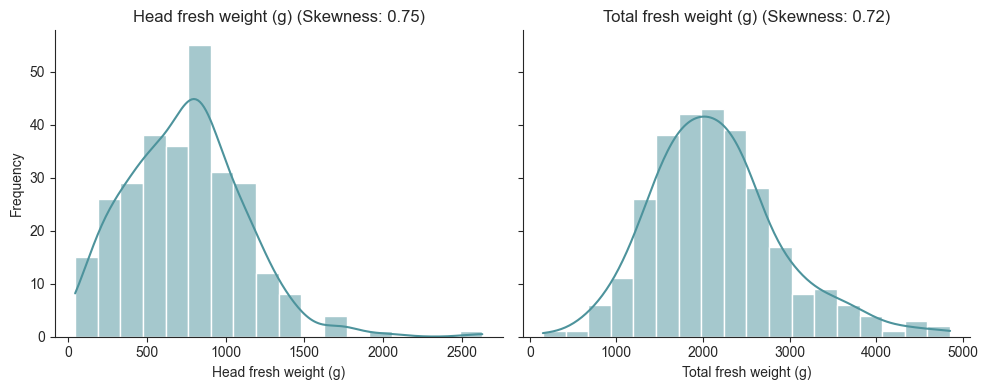

In [7]:
print("HISTOGRAMS OF NUMERICAL VALUES (in final_harvest_data):")
sns.set_style("ticks")

fig, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

sns.histplot(final_harvest_data["Head fresh weight (g)"], color = "#4D939C", kde = True, ax = axes[0])
sns.despine()
axes[0].set_title(f'Head fresh weight (g) (Skewness: {round(final_harvest_data["Head fresh weight (g)"].skew(), 2)})')
axes[0].set_ylabel("Frequency")

sns.histplot(final_harvest_data["Total fresh weight (g)"], color = "#4D939C", kde = True, ax = axes[1])
sns.despine()
axes[1].set_title(f'Total fresh weight (g) (Skewness: {round(final_harvest_data["Total fresh weight (g)"].skew(), 2)})')
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

##### 1.2.3 **Removing Invalid Rows and Outlier Analysis**

In [8]:
# Check for invalid rows

# Check for rows where Head fresh weight (g) > Total fresh weight (g)
invalid_rows = final_harvest_data[final_harvest_data["Head fresh weight (g)"] > final_harvest_data["Total fresh weight (g)"]]

print("ROWS WHERE Head fresh weight (g) IS GREATER THEN Total fresh weight (g):")
display(invalid_rows)

ROWS WHERE Head fresh weight (g) IS GREATER THEN Total fresh weight (g):


,ID,Crop type,Water treatment,Fertiliser treatment,Total fresh weight (g),Head fresh weight (g)
203,2A60,Broccoli,W+,N+,151.6,797.3


In [9]:
# Remove invalid rows from final_harvest_data
final_harvest_data = final_harvest_data[~(final_harvest_data["Head fresh weight (g)"] > final_harvest_data["Total fresh weight (g)"])]
print(final_harvest_data.shape)

(284, 6)


OUTLIER ANALYSIS Head fresh weight (g):


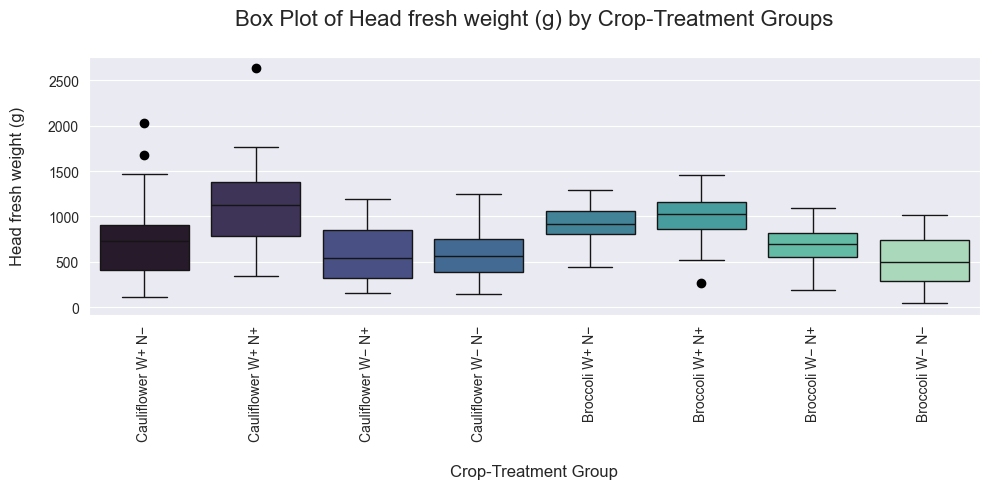

,ID,Crop type,Water treatment,Fertiliser treatment,Total fresh weight (g),Head fresh weight (g),Crop-treatment group
498,4A68,Broccoli,W+,N+,1409.4,270.2,Broccoli W+ N+
334,3A48,Cauliflower,W+,N+,4485.5,2630.3,Cauliflower W+ N+
14,1A15,Cauliflower,W+,N-,4851.2,2024.4,Cauliflower W+ N−
306,3A20,Cauliflower,W+,N-,4364.7,1679.8,Cauliflower W+ N−



OUTLIER ANALYSIS Total fresh weight (g):


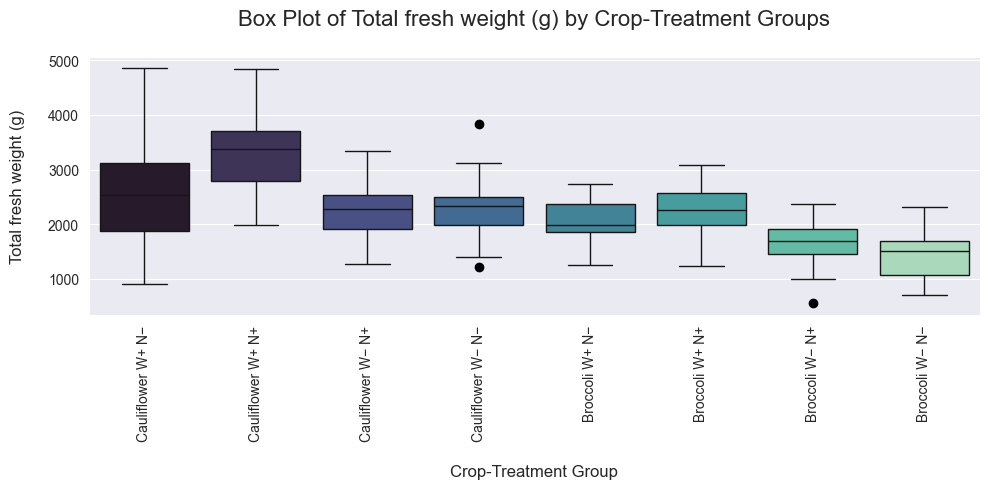

,ID,Crop type,Water treatment,Fertiliser treatment,Total fresh weight (g),Head fresh weight (g),Crop-treatment group
532,4A102,Broccoli,W-,N+,554.5,184.8,Broccoli W− N+
105,1A106,Cauliflower,W-,N-,3836.4,1222.1,Cauliflower W− N−
113,1A114,Cauliflower,W-,N-,1219.5,340.8,Cauliflower W− N−


In [10]:
# Boxplot per crop-treatment group to spot group-specific outliers

outlier_analysis = final_harvest_data.copy()
outlier_analysis.loc[:, "Crop-treatment group"] = outlier_analysis.apply(
    lambda row: f'{row["Crop type"]} {row["Water treatment"].replace("-", "−").replace("+", "+")} {row["Fertiliser treatment"].replace("-", "−").replace("+", "+")}',
    axis = 1
)

sns.set_style("darkgrid")

flierprops = {
    "marker": "o",
    "markerfacecolor": "black",
    "markeredgecolor": "black",
    "markersize": 6
}

# Head fresh weight (g)
print("OUTLIER ANALYSIS Head fresh weight (g):")
plt.figure(figsize = (10, 5))

sns.boxplot(
    data       = outlier_analysis,
    x          = "Crop-treatment group",
    y          = "Head fresh weight (g)",
    palette    = "mako",
    hue        = "Crop-treatment group",
    legend     = False,
    flierprops = flierprops
)

plt.title("Box Plot of Head fresh weight (g) by Crop-Treatment Groups\n", fontsize = 16)
plt.xlabel("\nCrop-Treatment Group", fontsize = 12)
plt.ylabel("Head fresh weight (g)\n", fontsize = 12)
plt.xticks(rotation = 90, ha = "center", fontsize = 10)

plt.tight_layout()
plt.show()

# Identify (Head fresh weight (g)) outliers from the boxplot in row format
outliers = []

for group, group_data in outlier_analysis.groupby("Crop-treatment group"):
    Q1  = group_data["Head fresh weight (g)"].quantile(0.25)
    Q3  = group_data["Head fresh weight (g)"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    group_outliers = group_data[(group_data["Head fresh weight (g)"] < lower_bound) | (group_data["Head fresh weight (g)"] > upper_bound)]
    outliers.append(group_outliers)

outliers = pd.concat(outliers)

display(outliers)

# Total fresh weight (g)
print("\nOUTLIER ANALYSIS Total fresh weight (g):")
plt.figure(figsize = (10, 5))

sns.boxplot(
    data       = outlier_analysis,
    x          = "Crop-treatment group",
    y          = "Total fresh weight (g)",
    palette    = "mako",
    hue        = "Crop-treatment group",
    legend     = False,
    flierprops = flierprops
)

plt.title("Box Plot of Total fresh weight (g) by Crop-Treatment Groups\n", fontsize = 16)
plt.xlabel("\nCrop-Treatment Group", fontsize = 12)
plt.ylabel("Total fresh weight (g)\n", fontsize = 12)
plt.xticks(rotation = 90, ha = "center", fontsize = 10)

plt.tight_layout()
plt.show()

# Identify (Total fresh weight (g)) outliers from the boxplot in row format
outliers = []

for group, group_data in outlier_analysis.groupby("Crop-treatment group"):
    Q1  = group_data["Total fresh weight (g)"].quantile(0.25)
    Q3  = group_data["Total fresh weight (g)"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    group_outliers = group_data[(group_data["Total fresh weight (g)"] < lower_bound) | (group_data["Total fresh weight (g)"] > upper_bound)]
    outliers.append(group_outliers)

outliers = pd.concat(outliers)

display(outliers)

##### 1.2.4 **Subgroup Analysis**

In [11]:
# Distribution of subgroups in final_harvest_data
col_width = 15

print("DISTRIBUTION OF CROP TYPES (in final_harvest_data):")
print(f'{"Broccoli":<{col_width}} {len(final_harvest_data[final_harvest_data["Crop type"] == "Broccoli"])}')
print(f'{"Cauliflower":<{col_width}} {len(final_harvest_data[final_harvest_data["Crop type"] == "Cauliflower"])}')

print("\nDISTRIBUTION OF CROP-TREATMENT GROUPS (in final_harvest_data):")
group_totals = final_harvest_data.groupby(["Crop type", "Water treatment", "Fertiliser treatment"]).size()
print(group_totals)

DISTRIBUTION OF CROP TYPES (in final_harvest_data):
Broccoli        148
Cauliflower     136

DISTRIBUTION OF CROP-TREATMENT GROUPS (in final_harvest_data):
Crop type    Water treatment  Fertiliser treatment
Broccoli     W+               N+                      31
                              N-                      35
             W-               N+                      38
                              N-                      44
Cauliflower  W+               N+                      28
                              N-                      32
             W-               N+                      34
                              N-                      42
dtype: int64


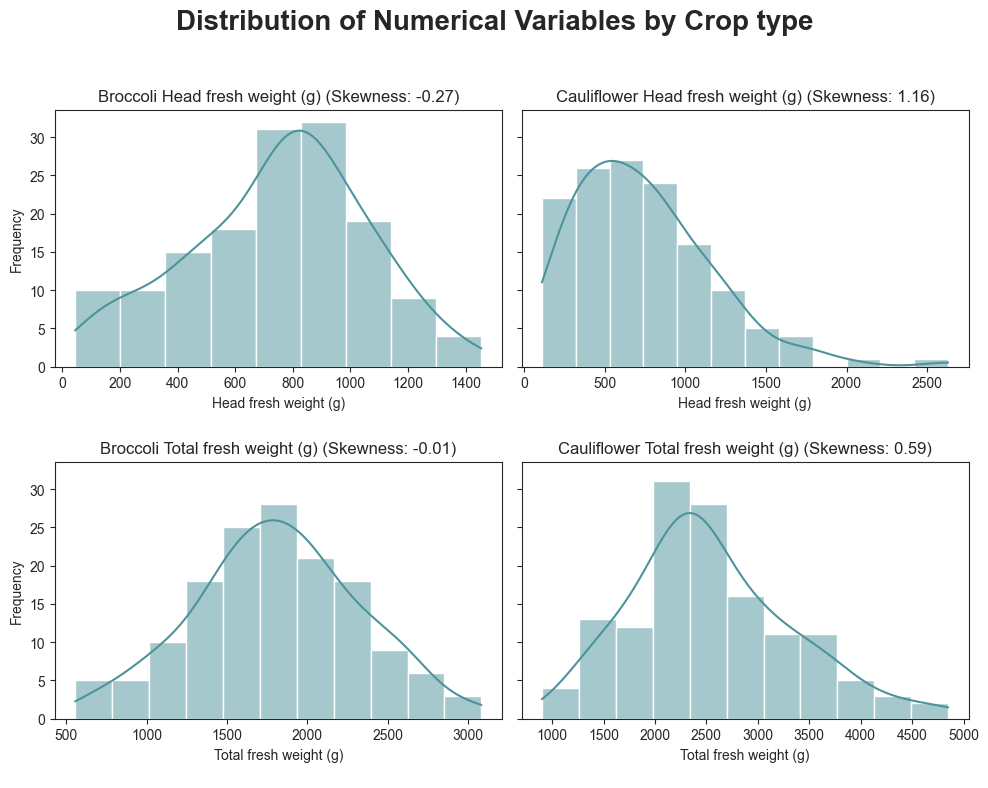

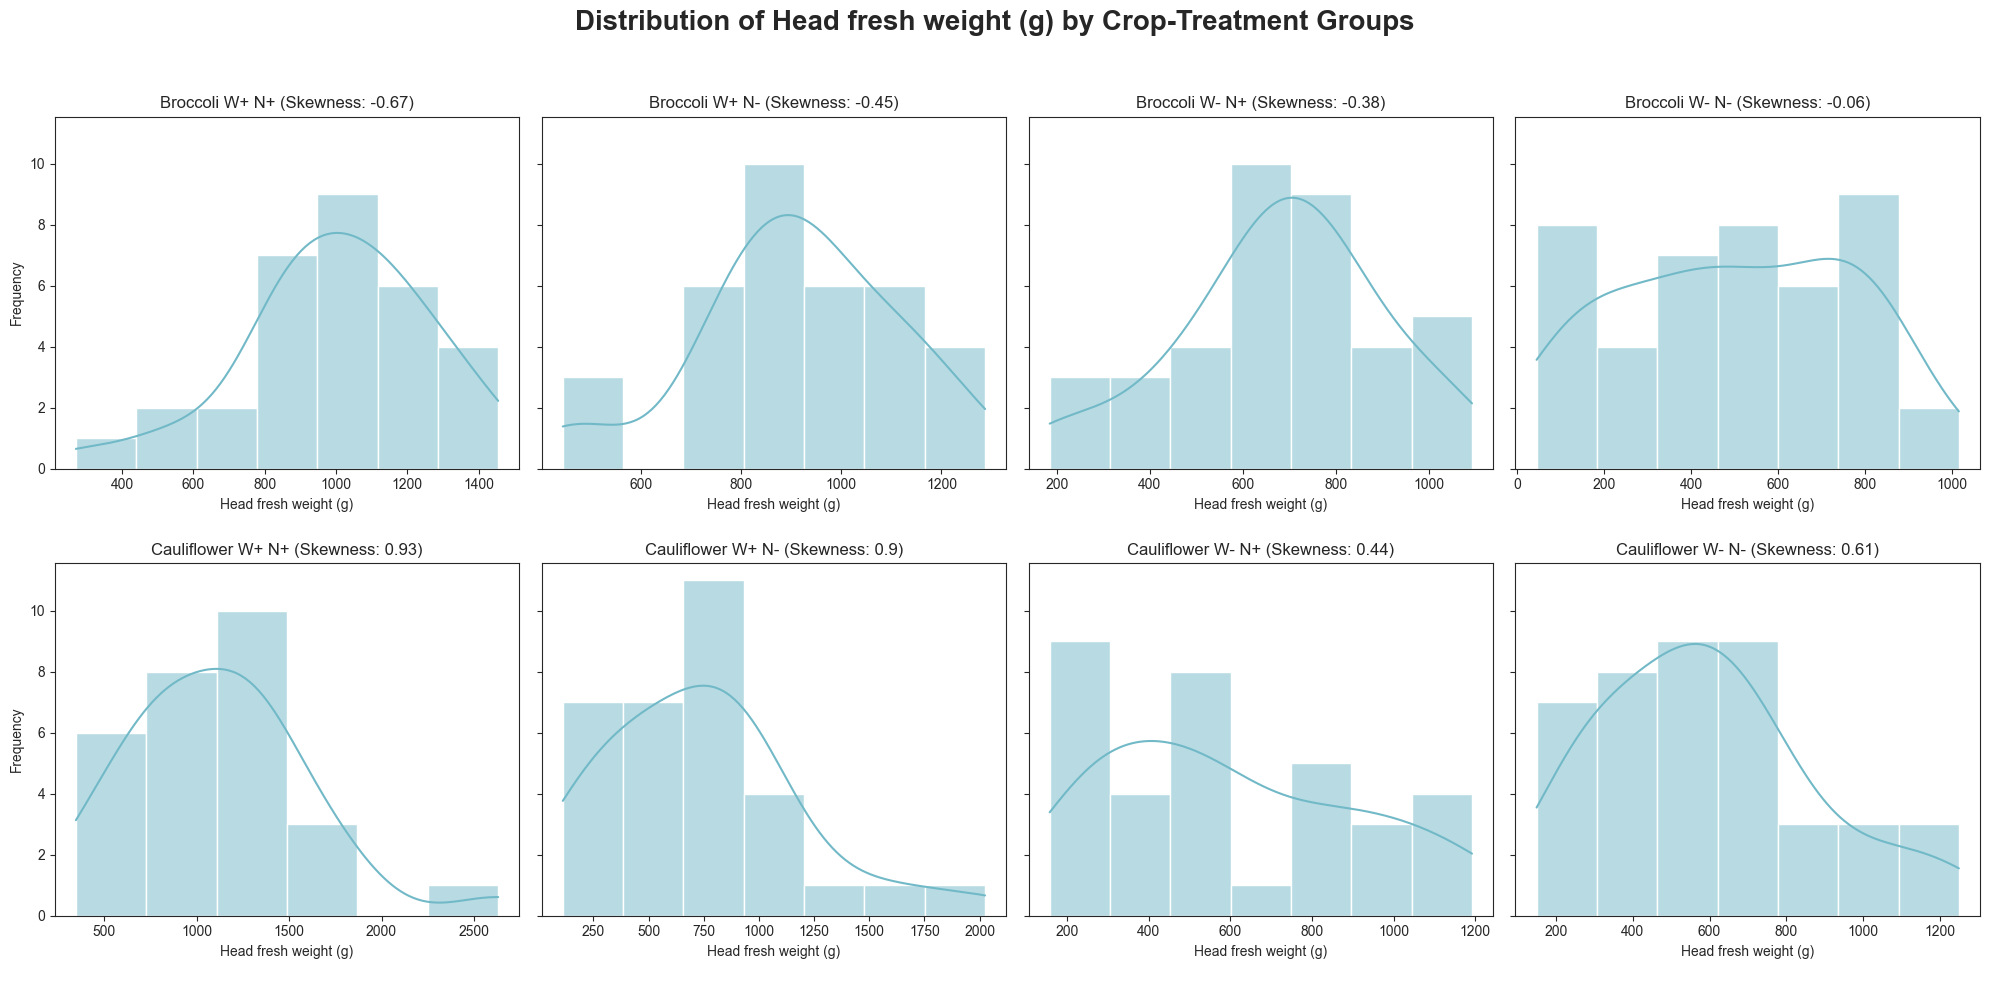

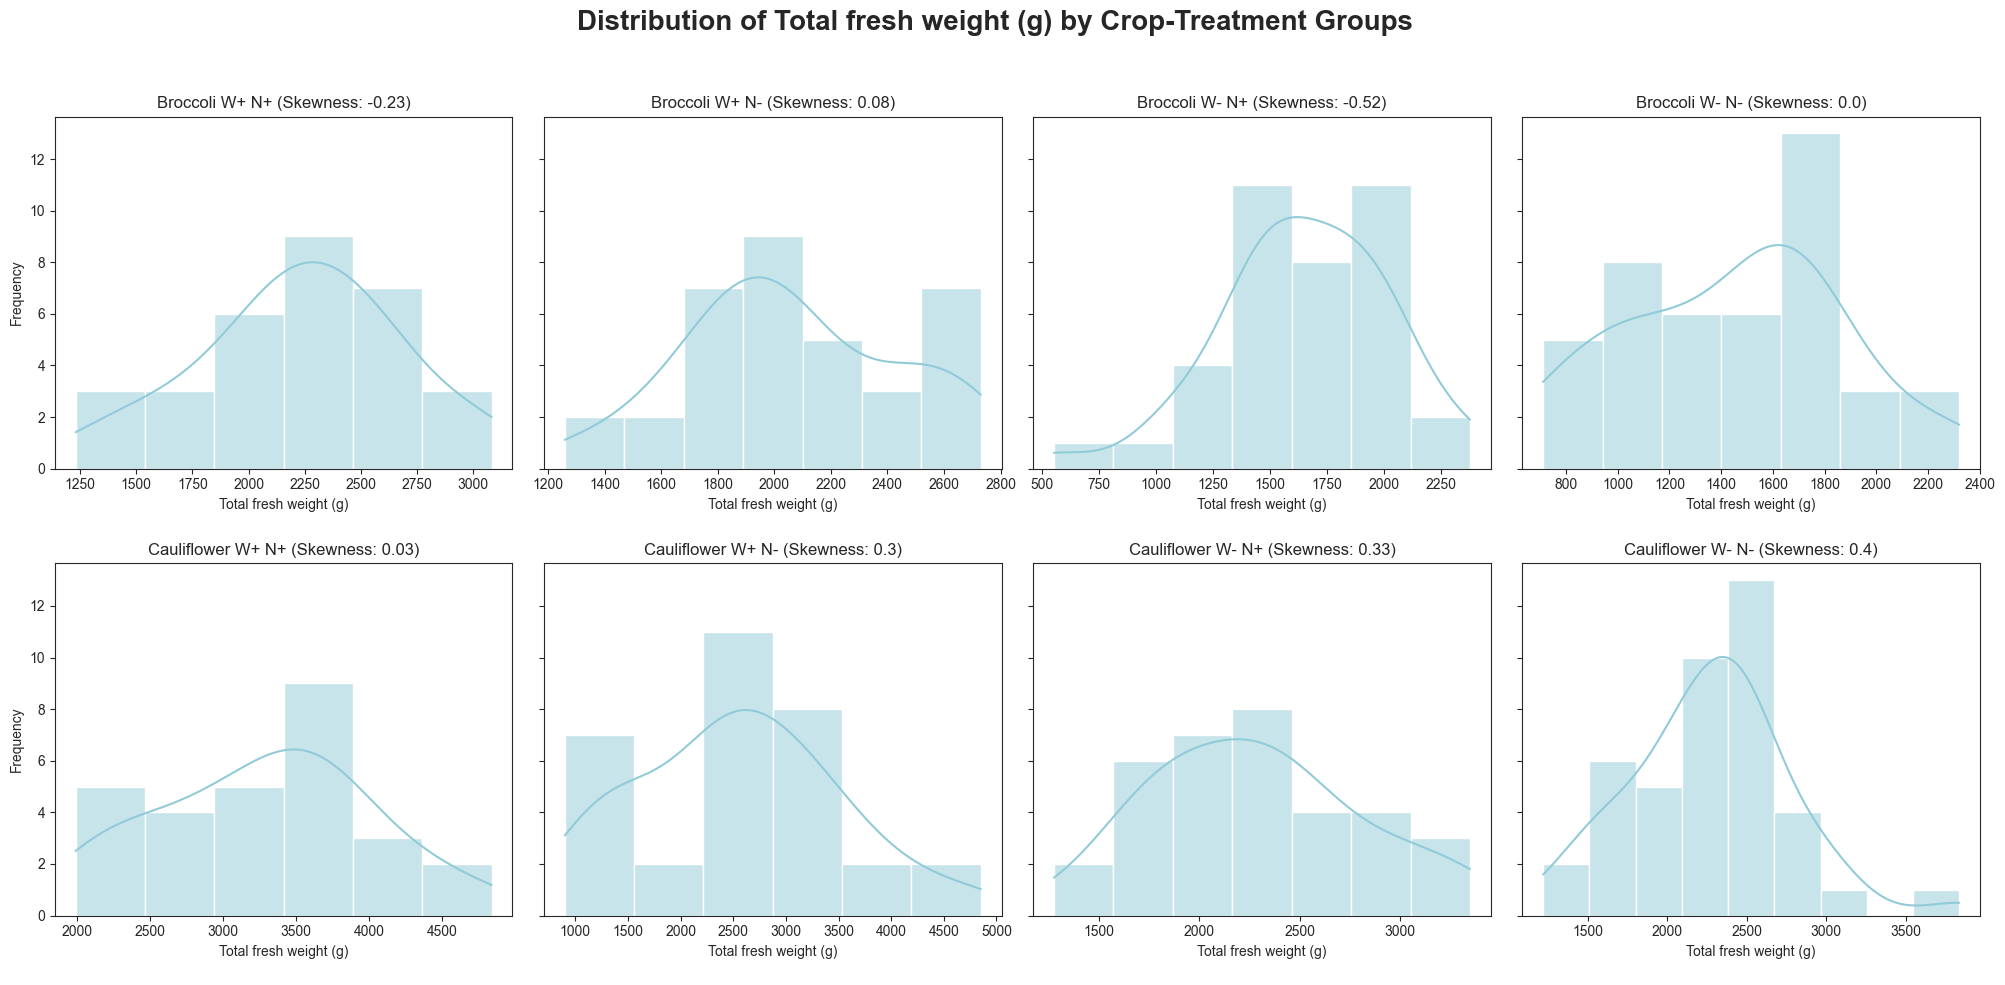

In [14]:
sns.set_style("ticks")


# Histogram per crop type

subgroups = final_harvest_data.groupby("Crop type")

fig, axes = plt.subplots(2, 2, figsize = (10, 8), sharey = True)

# HFW
for i, (name, group) in enumerate(subgroups):
    sns.histplot(group["Head fresh weight (g)"], color = "#4D939C", kde = True, ax = axes[0, i])
    axes[0, i].set_title(f'{name} Head fresh weight (g) (Skewness: {round(group["Head fresh weight (g)"].skew(), 2)})')
    axes[0, i].set_xlabel("Head fresh weight (g)\n")
    axes[0, i].set_ylabel("Frequency")

# TFW
for i, (name, group) in enumerate(subgroups):
    sns.histplot(group["Total fresh weight (g)"], color = "#4D939C", kde = True, ax = axes[1, i])
    axes[1, i].set_title(f'{name} Total fresh weight (g) (Skewness: {round(group["Total fresh weight (g)"].skew(), 2)})')
    axes[1, i].set_xlabel("Total fresh weight (g)\n")
    axes[1, i].set_ylabel("Frequency")

fig.suptitle("Distribution of Numerical Variables by Crop type", fontsize = 20, weight = "bold")
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()


# Histogram per crop-treatment group

subgroups = final_harvest_data.groupby(["Crop type", "Water treatment", "Fertiliser treatment"])

# HFW
fig, axes = plt.subplots(2, 4, figsize = (20, 10), sharey = True)
axes = axes.flatten()

for ax, (name, group) in zip(axes, subgroups):
    groupname = " ".join(name)
    sns.histplot(group["Head fresh weight (g)"], color = "#72B9C8", kde = True, ax = ax)
    ax.set_title(f'{groupname} (Skewness: {round(group["Head fresh weight (g)"].skew(), 2)})')
    ax.set_xlabel("Head fresh weight (g)\n")
    ax.set_ylabel("Frequency")

fig.suptitle("Distribution of Head fresh weight (g) by Crop-Treatment Groups", fontsize = 20, weight = "bold")
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()

# TFW
fig, axes = plt.subplots(2, 4, figsize = (20, 10), sharey = True)
axes = axes.flatten()

for ax, (name, group) in zip(axes, subgroups):
    groupname = " ".join(name)
    sns.histplot(group["Total fresh weight (g)"], color = "#91CBD8", kde = True, ax = ax)
    ax.set_title(f'{groupname} (Skewness: {round(group["Total fresh weight (g)"].skew(), 2)})')
    ax.set_xlabel("Total fresh weight (g)\n")
    ax.set_ylabel("Frequency")

fig.suptitle("Distribution of Total fresh weight (g) by Crop-Treatment Groups", fontsize = 20, weight = "bold")
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()

##### 1.2.5 **Correlation Analysis**

CORRELATIONS INDEPENDENT OF Crop type:


,Total fresh weight (g),Head fresh weight (g)
Crop type,-0.489043,0.012104
Water treatment,0.397776,0.463047
Fertiliser treatment,0.169138,0.218349
Total fresh weight (g),1.000000,0.748658
Head fresh weight (g),0.748658,1.000000


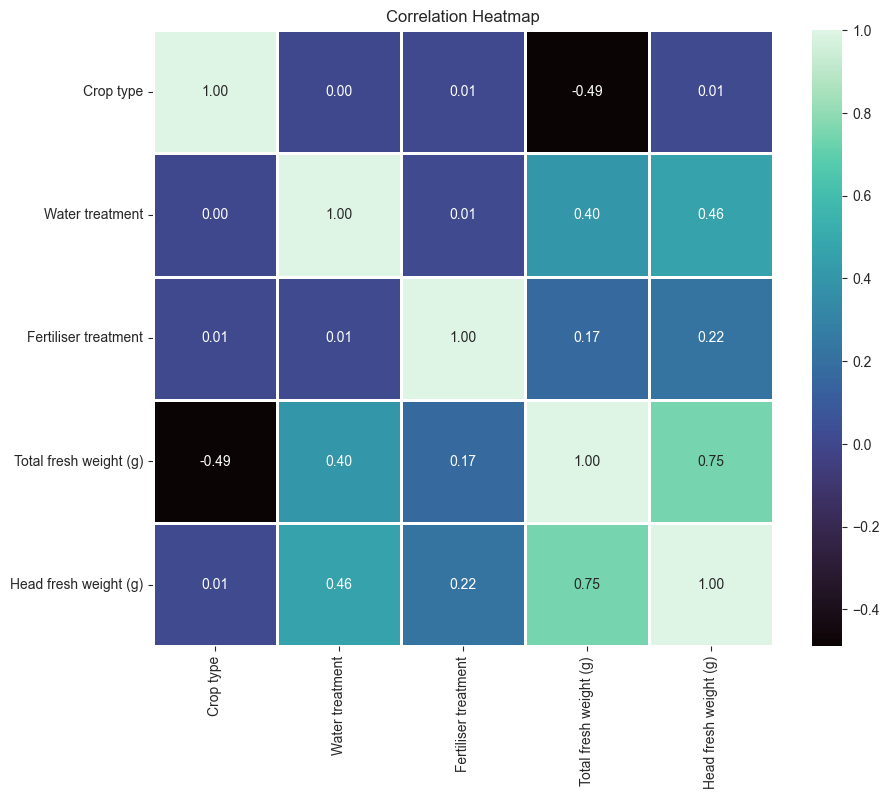

CORRELATIONS Cauliflower:


,Total fresh weight (g),Head fresh weight (g)
Water treatment,0.388093,0.371426
Fertiliser treatment,0.216827,0.212053
Total fresh weight (g),1.000000,0.830155
Head fresh weight (g),0.830155,1.000000


CORRELATIONS Broccoli:


,Total fresh weight (g),Head fresh weight (g)
Water treatment,0.583158,0.592402
Fertiliser treatment,0.186498,0.232453
Total fresh weight (g),1.000000,0.936522
Head fresh weight (g),0.936522,1.000000


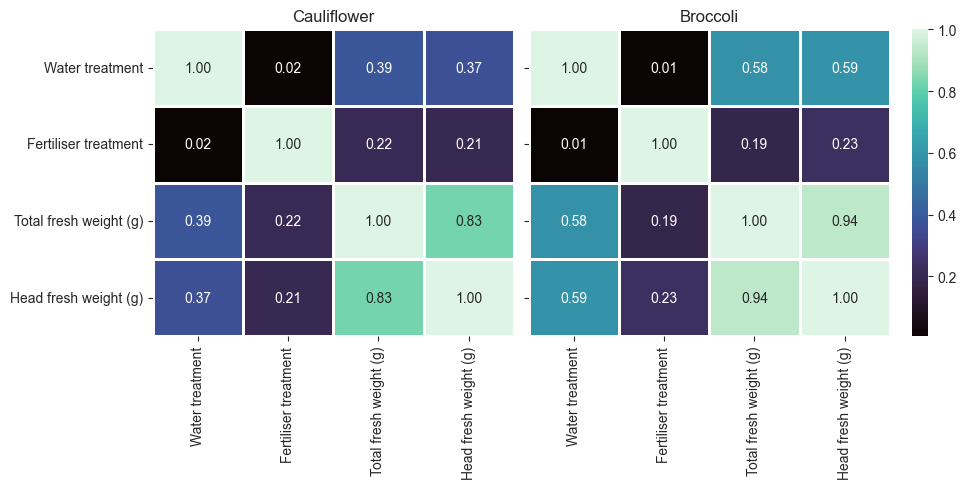

In [32]:
mapped = final_harvest_data.copy()
mapped = mapped.drop(columns = "ID")

mapped["Crop type"]            = mapped["Crop type"].map({"Cauliflower": 1, "Broccoli": 2})
mapped["Water treatment"]      = mapped["Water treatment"].map({"W+": 1, "W-": 0})
mapped["Fertiliser treatment"] = mapped["Fertiliser treatment"].map({"N+": 1, "N-": 0})

correlations = mapped.corr()

print("CORRELATIONS INDEPENDENT OF Crop type:")
filter_correlations = correlations[["Total fresh weight (g)", "Head fresh weight (g)"]]
display(filter_correlations)

plt.figure(figsize = (10, 8))
sns.heatmap(correlations, annot = True, fmt = ".2f", cmap = "mako", linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()


# Correlations depending on Crop type

# Cauliflower
mapped1 = mapped.copy()
mapped1 = mapped1[mapped1["Crop type"] == 1]
mapped1 = mapped1.drop(columns = "Crop type")

print("CORRELATIONS Cauliflower:")
correlations1 = mapped1.corr()
filter_correlations1 = correlations1[["Total fresh weight (g)", "Head fresh weight (g)"]]
display(filter_correlations1)

# Broccoli
mapped2 = mapped.copy()
mapped2 = mapped2[mapped2["Crop type"] == 2]
mapped2 = mapped2.drop(columns = "Crop type")

print("CORRELATIONS Broccoli:")
correlations2 = mapped2.corr()
filter_correlations2 = correlations2[["Total fresh weight (g)", "Head fresh weight (g)"]]
display(filter_correlations2)

fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True, width_ratios = [4, 5])

sns.heatmap(correlations1, annot = True, fmt = ".2f", cmap = "mako", linewidths = 2, ax = axes[0], cbar = False)
axes[0].set_title("Cauliflower")

sns.heatmap(correlations2, annot = True, fmt = ".2f", cmap = "mako", linewidths = 2, ax = axes[1])
axes[1].set_title("Broccoli")

plt.tight_layout()
plt.show()

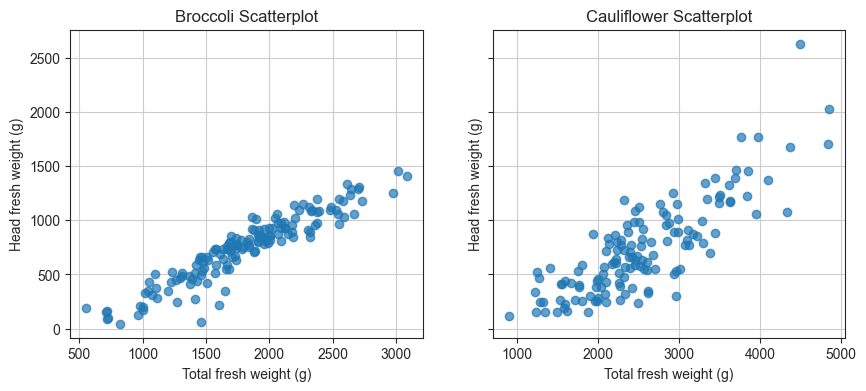

,Crop type,Total fresh weight W,Total fresh weight p-value,Head fresh weight W,Head fresh weight p-value
0,Broccoli,0.9941,0.8080 (8.08e-01),0.9838,0.0790 (7.90e-02)
1,Cauliflower,0.9731,0.0085 (8.53e-03),0.9287,0.0000 (2.29e-06)


In [28]:
# Checking if the distributions are normal (for: Pearson, Spearman)

subgroups = final_harvest_data.groupby("Crop type")

results = []

fig, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

for (name, group), ax in zip(subgroups, axes):
    shapiro_TFW = shapiro(group["Total fresh weight (g)"])
    shapiro_HFW = shapiro(group["Head fresh weight (g)"])

    results.append({
        "Crop type": name,
        "Total fresh weight W": f'{shapiro_TFW[0]:.4f}',
        "Total fresh weight p-value": f'{shapiro_TFW[1]:.4f} ({shapiro_TFW[1]:.2e})',
        "Head fresh weight W": f'{shapiro_HFW[0]:.4f}',
        "Head fresh weight p-value": f'{shapiro_HFW[1]:.4f} ({shapiro_HFW[1]:.2e})'
    })

    ax.scatter(group["Total fresh weight (g)"], group["Head fresh weight (g)"], alpha=0.7)
    ax.set_title(f"{name} Scatterplot")
    ax.set_xlabel("Total fresh weight (g)")
    ax.set_ylabel("Head fresh weight (g)")
    ax.grid(True)

plt.show()

results = pd.DataFrame(results)
display(results)

In [29]:
# Correlations of Total fresh weight (g) onto Head fresh weight (g) depending on Crop type (Pearson, Spearman)

results = []

# Pearson correlation for Broccoli
final_harvest_data_B = final_harvest_data.copy()
final_harvest_data_B = final_harvest_data_B[final_harvest_data_B["Crop type"] == "Broccoli"]

xB = final_harvest_data_B["Total fresh weight (g)"]
yB = final_harvest_data_B["Head fresh weight (g)"]

pearson_correlation, pearson_p = pearsonr(xB, yB)

results.append({
    "Crop type": "Broccoli",
    "Correlation method": "Pearson",
    "Correlation score": f'{pearson_correlation:.4f}',
    "Correlation p-value": f'{pearson_p:.4f} ({pearson_p:.2e})'
})

# Spearman correlation for Cauliflower
final_harvest_data_C = final_harvest_data.copy()
final_harvest_data_C = final_harvest_data_C[final_harvest_data_C["Crop type"] == "Cauliflower"]

xC = final_harvest_data_C["Total fresh weight (g)"]
yC = final_harvest_data_C["Head fresh weight (g)"]

spearman_correlation, spearman_p = spearmanr(xC, yC)

results.append({
    "Crop type": "Cauliflower",
    "Correlation method": "Spearman",
    "Correlation score": f'{spearman_correlation:.4f}',
    "Correlation p-value": f'{spearman_p:.4f} ({spearman_p:.2e})'
})

# Results
results = pd.DataFrame(results)
display(results)

,Crop type,Correlation method,Correlation score,Correlation p-value
0,Broccoli,Pearson,0.9365,0.0000 (2.46e-68)
1,Cauliflower,Spearman,0.7903,0.0000 (2.68e-30)


#### 1.3 **Export Data File**

In [30]:
exp_csv_path = os.path.join(target_dir, "B_processed_data", "B_crop_data.csv")
final_harvest_data.to_csv(exp_csv_path, index = False)

## **DATA FILE 2**: `soil_data.csv`

#### 2.1 **Import Raw Data and Initial Cleaning**

In [20]:
imp_csv_path = os.path.join(target_dir, "A_raw_data", "insitu", "soil_data.csv")
soil_data = pd.read_csv(imp_csv_path, header = [0, 1, 2, 3, 4])

# Flatten multi-level header
soil_data.columns = ["_".join(col).strip() for col in soil_data.columns.values]
# Set index
soil_data["Bed_Depth_Zone_Variable_Date time"] = pd.to_datetime(soil_data["Bed_Depth_Zone_Variable_Date time"], errors = "coerce")
soil_data = soil_data.set_index("Bed_Depth_Zone_Variable_Date time")
# Rename index
soil_data = soil_data.rename_axis("Date time")
# Clean up column headers
soil_data.columns = [col.split("_Unnamed:")[0].strip() for col in soil_data.columns]
soil_data.columns = soil_data.columns.str.replace("Water+", "W+", regex = False)
soil_data.columns = soil_data.columns.str.replace("Water-", "W-", regex = False)
soil_data.columns = soil_data.columns.str.replace("/Fertiliser+", "N+", regex = False)
soil_data.columns = soil_data.columns.str.replace("/Fertiliser-", "N-", regex = False)

#### 2.2 **Preprocessing and Exploratory Data Analysis**

##### 2.2.1 **Filter to Data Week 6**

In [21]:
# Remove everything after 6 weeks
start_date         = soil_data.index.min()
filtered_soil_data = soil_data[soil_data.index <= (start_date + pd.Timedelta(days = 41))]
end_date           = filtered_soil_data.index.max()

print("Start date: ", start_date)
print("End date:   ", end_date)
print("Days:       ", len(pd.date_range(start = start_date, end = end_date, freq = "D")))
print("Weeks:      ", len(pd.date_range(start = start_date, end = end_date, freq = "W")))

Start date:  2017-10-03 16:00:00
End date:    2017-11-13 16:00:00
Days:        42
Weeks:       6


##### 2.2.2 **Time Series Analysis**

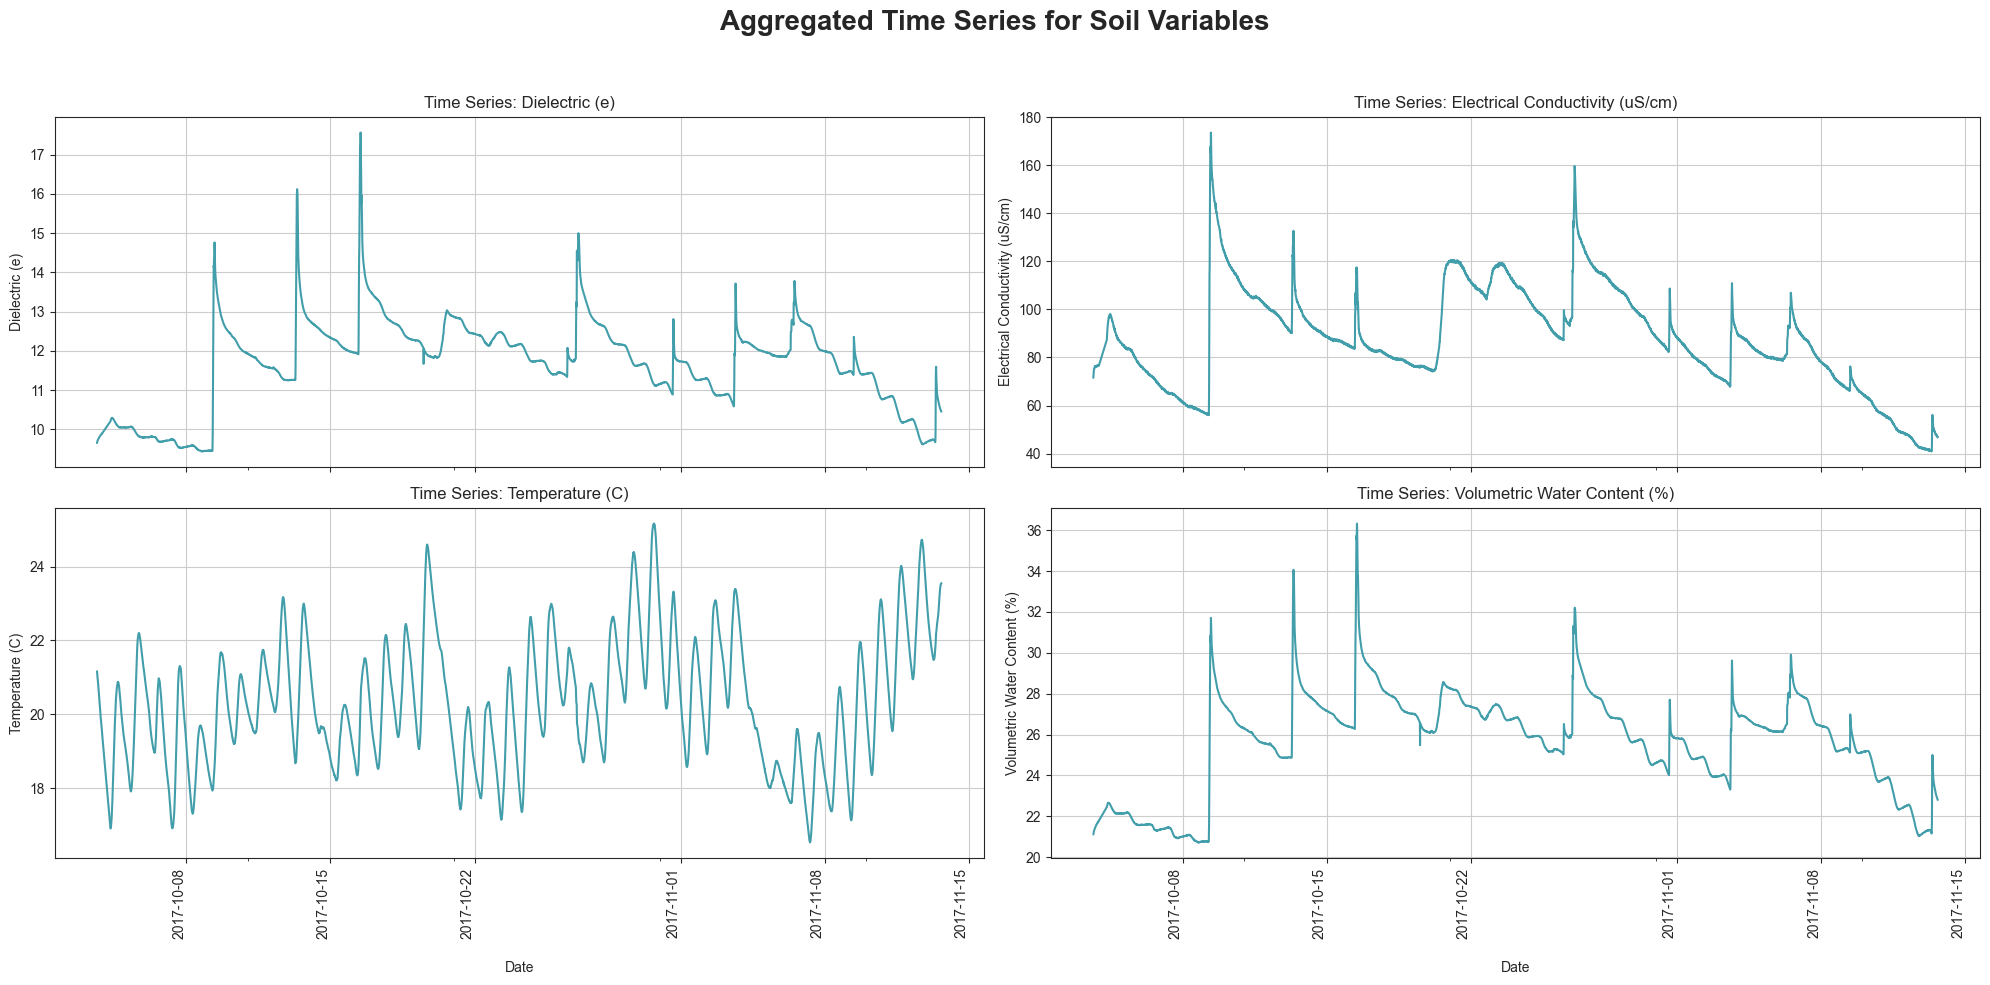

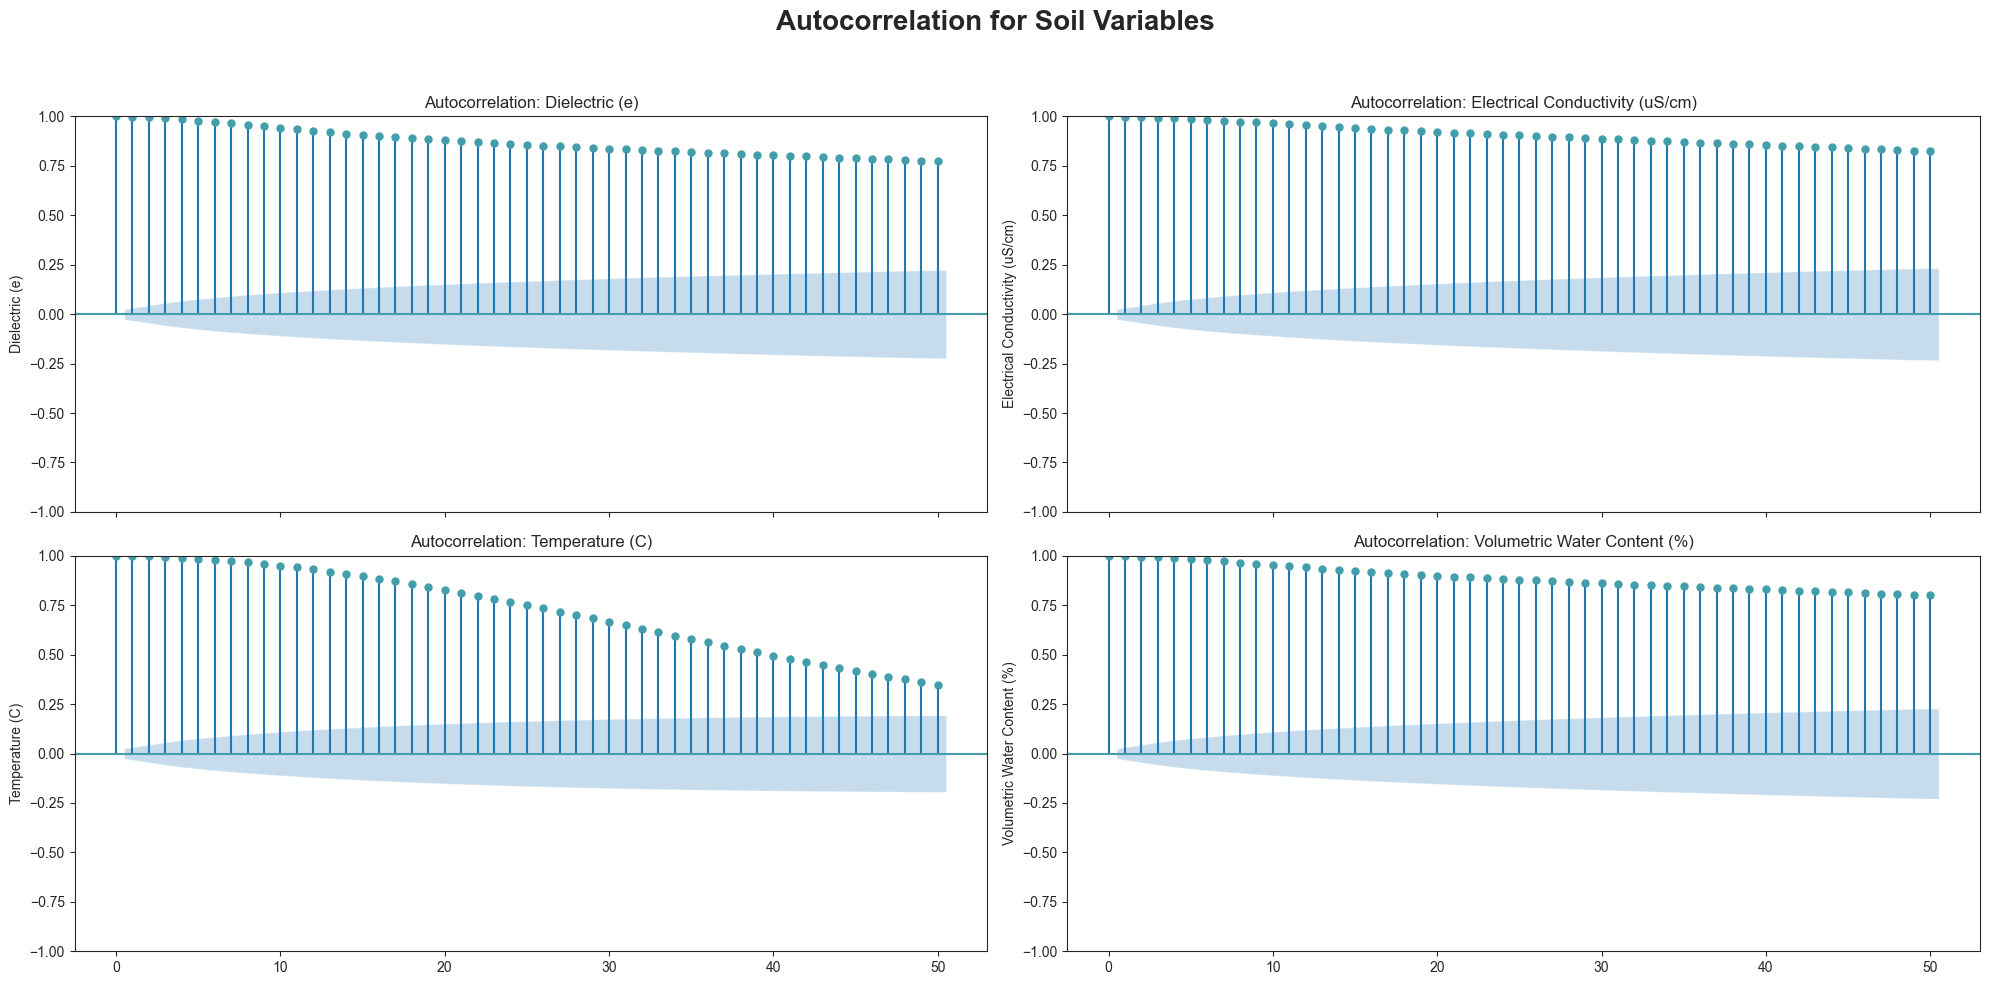

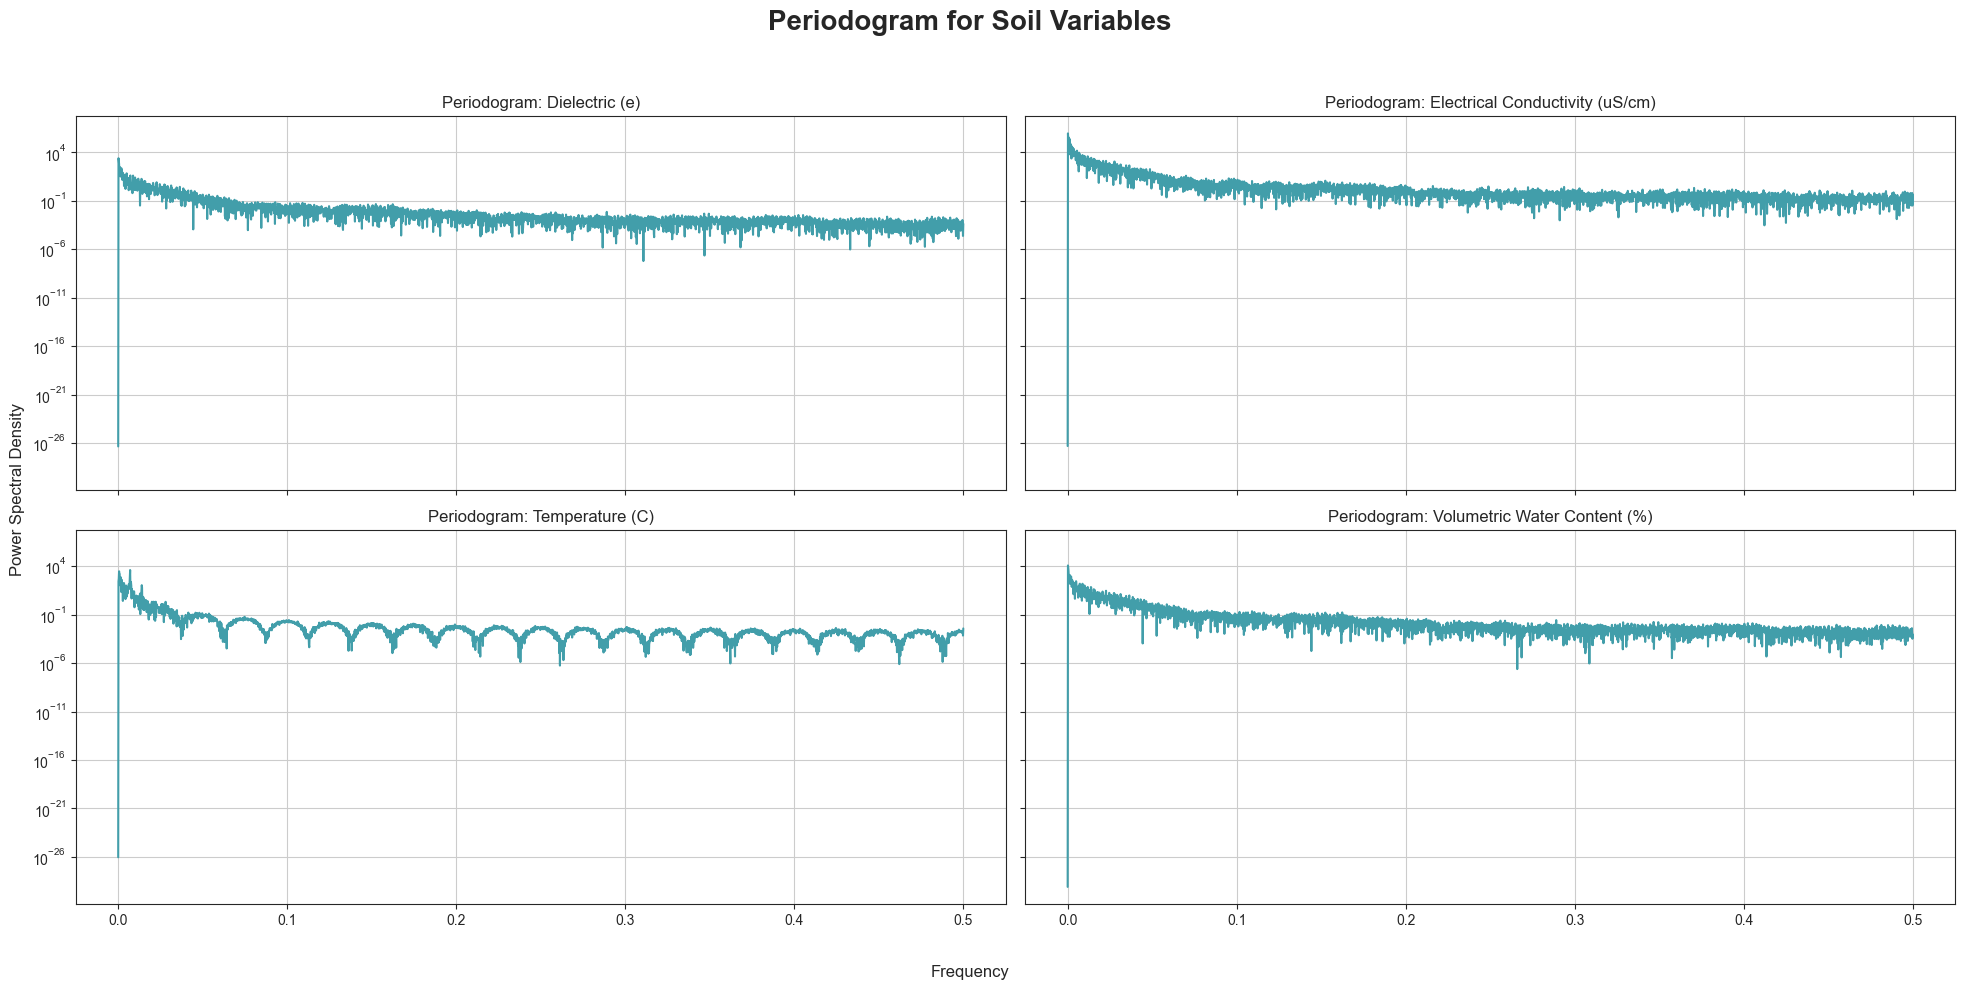

In [38]:
# Group columns by variable type
variables = {
    "Dielectric (e)":                  [col for col in filtered_soil_data.columns if "Dielectric (e)" in col],
    "Electrical Conductivity (uS/cm)": [col for col in filtered_soil_data.columns if "Electrical Conductivity" in col],
    "Temperature (C)":                 [col for col in filtered_soil_data.columns if "Temperature (C)" in col],
    "Volumetric Water Content (%)":    [col for col in filtered_soil_data.columns if "Volumetric Water Content" in col]
}

# Aggregate the data by computing the mean across all beds, zones, and depths
aggregated_data = {}
for var, cols in variables.items():
    aggregated_data[var] = filtered_soil_data[cols].mean(axis = 1)

aggregated_data = pd.DataFrame(aggregated_data)

# Time series per variable
fig, axes = plt.subplots(2, 2, figsize = (20, 10), sharex = True, sharey = False)
axes = axes.flatten()

for ax, (var, series) in zip(axes, aggregated_data.items()):
    series.plot(ax = ax, color = "#429eaa")
    ax.set_title(f"Time Series: {var}")
    ax.set_xlabel("\nDate")
    ax.set_ylabel(var)
    ax.grid(True)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

fig.suptitle("Aggregated Time Series for Soil Variables", fontsize = 20, weight = "bold")
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()

# Autocorrelation per variable
fig, axes = plt.subplots(2, 2, figsize = (20, 10), sharex = True, sharey = False)
axes = axes.flatten()

for ax, (var, series) in zip(axes, aggregated_data.items()):
    plot_acf(series.dropna(), lags = 50, ax = ax, title = f"Autocorrelation: {var}", color = "#429eaa")
    ax.set_ylabel(var)
    ax.grid(False)

fig.suptitle("Autocorrelation for Soil Variables", fontsize = 20, weight = "bold")
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()

# Periodogram for frequency content per variable
fig, axes = plt.subplots(2, 2, figsize = (20, 10), sharex = True, sharey = True)
axes = axes.flatten()

for ax, (var, series) in zip(axes, aggregated_data.items()):
    freqs, psd = periodogram(series.dropna(), fs = 1)
    ax.semilogy(freqs, psd, color = "#429eaa")
    ax.set_title(f"Periodogram: {var}")
    ax.grid(True)

fig.supxlabel("\nFrequency")
fig.supylabel("Power Spectral Density\n")
fig.suptitle("Periodogram for Soil Variables", fontsize = 20, weight = "bold")
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()

##### 2.2.3 **Resampling and Feature Engineering**

In [39]:
missing_values = filtered_soil_data.isnull().sum()
print("Total number of missing values in the data: ", missing_values.sum())

# Resample with mean for average state, and sum for cumulative impact (no missing values in the dataset)
resample_columns_mean = [col for col in filtered_soil_data.columns if any(keyword in col for keyword in ["Dielectric", "Electrical Conductivity"])]
resample_columns_sum  = [col for col in filtered_soil_data.columns if any(keyword in col for keyword in ["Volumetric Water Content"])]
resampled_data_mean   = filtered_soil_data[resample_columns_mean].resample("7D").mean().round(1)
resampled_data_sum    = filtered_soil_data[resample_columns_sum].resample("7D").sum().round(1)
# Specify column names
resampled_data_mean.columns = [f"{col}_mean" for col in resampled_data_mean.columns]
resampled_data_sum.columns  = [f"{col}_sum" for col in resampled_data_sum.columns]

# Resample Temperature (C) with aggregate statistics
resample_columns_temp = [col for col in filtered_soil_data.columns if any(keyword in col for keyword in ["Temperature"])]
resampled_data_temp   = filtered_soil_data[resample_columns_temp].resample("7D").agg(["max", "mean", "std"]).round(1)
# Flatten column names 
resampled_data_temp.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in resampled_data_temp.columns]

# Combine into resampled_soil_data
resampled_soil_data = pd.concat([resampled_data_mean, resampled_data_sum, resampled_data_temp], axis = 1)

# Add week numbers to resampled_soil_data
resampled_soil_data         = resampled_soil_data.reset_index()
resampled_soil_data["Week"] = resampled_soil_data["Date time"].rank(method = "dense").astype(int)
resampled_soil_data_long    = resampled_soil_data.melt(id_vars = ["Week"], var_name = "Feature", value_name = "Value")
resampled_soil_data_long[["Bed", "Depth", "Treatment", "Variable", "Method"]] = resampled_soil_data_long["Feature"].str.split("_", expand=True)

resampled_soil_data_long[""] = (
    "W" + 
    resampled_soil_data_long["Week"].astype(str) + "_" +
    resampled_soil_data_long["Depth"] + "_" +
    resampled_soil_data_long["Variable"] + "_" +
    resampled_soil_data_long["Method"]
)

# Pivot
resampled_soil_data_wide = resampled_soil_data_long.pivot_table(index = ["Bed", "Treatment"], columns = "", values = "Value").reset_index()

display(resampled_soil_data_wide)

Total number of missing values in the data:  0


,Bed,Treatment,W1_10cm_Dielectric (e)_mean,W1_10cm_Electrical Conductivity (uS/cm)_mean,W1_10cm_Temperature (C)_max,W1_10cm_Temperature (C)_mean,W1_10cm_Temperature (C)_std,W1_10cm_Volumetric Water Content (%)_sum,W1_30cm_Dielectric (e)_mean,W1_30cm_Electrical Conductivity (uS/cm)_mean,...,W6_10cm_Temperature (C)_max,W6_10cm_Temperature (C)_mean,W6_10cm_Temperature (C)_std,W6_10cm_Volumetric Water Content (%)_sum,W6_30cm_Dielectric (e)_mean,W6_30cm_Electrical Conductivity (uS/cm)_mean,W6_30cm_Temperature (C)_max,W6_30cm_Temperature (C)_mean,W6_30cm_Temperature (C)_std,W6_30cm_Volumetric Water Content (%)_sum
0,1,W+N+,9.9,73.7,24.1,19.3,2.2,18583.8,11.5,82.6,...,26.3,20.1,2.8,24761.8,13.3,120.7,22.9,19.9,1.5,27962.0
1,1,W+N-,9.2,113.3,25.1,19.6,2.4,17269.8,10.0,36.5,...,26.5,20.0,2.9,25323.7,12.6,68.3,23.7,20.5,1.7,26560.3
2,1,W-N+,11.0,134.4,24.5,19.4,2.4,20791.4,10.9,86.4,...,27.7,20.7,3.4,19885.8,11.8,70.4,24.0,20.3,1.9,25054.5
3,1,W-N-,9.6,56.3,24.9,19.6,2.5,17938.5,7.9,96.9,...,28.3,21.1,3.6,18087.1,8.5,121.0,24.0,20.7,1.9,17623.6
4,2,W+N+,10.1,59.9,25.2,20.0,2.4,19167.0,10.3,33.2,...,24.5,19.8,2.3,23424.9,14.6,94.2,22.8,19.9,1.5,30171.3
5,2,W+N-,8.6,105.1,25.3,19.6,2.7,16148.7,8.9,26.1,...,25.4,19.7,2.6,21854.2,11.1,69.6,23.2,20.1,1.6,23522.0
6,2,W-N+,10.5,120.5,24.2,19.7,2.0,19789.6,10.9,36.3,...,27.3,21.0,3.1,21753.7,13.1,86.4,24.4,20.7,1.9,27500.5
7,2,W-N-,10.2,65.4,24.7,19.5,2.3,19313.3,9.0,27.3,...,27.1,20.8,3.2,19753.5,9.9,42.9,24.4,20.8,1.9,20902.1
8,3,W+N+,9.2,49.7,23.5,20.0,1.8,17337.1,11.1,45.8,...,24.7,20.2,2.2,22175.5,13.7,69.9,23.4,20.6,1.5,28581.0
9,3,W+N-,8.5,55.8,25.2,20.5,2.2,15753.8,9.2,16.3,...,28.0,21.5,3.1,22676.2,12.8,69.1,24.6,21.1,1.8,27028.6


##### 2.2.4 **Correlation Analysis**

,ID,Crop type,Water treatment,Fertiliser treatment,Total fresh weight (g),Head fresh weight (g),Treatment,Bed,W1_10cm_Dielectric (e)_mean,W1_10cm_Electrical Conductivity (uS/cm)_mean,...,W6_10cm_Temperature (C)_max,W6_10cm_Temperature (C)_mean,W6_10cm_Temperature (C)_std,W6_10cm_Volumetric Water Content (%)_sum,W6_30cm_Dielectric (e)_mean,W6_30cm_Electrical Conductivity (uS/cm)_mean,W6_30cm_Temperature (C)_max,W6_30cm_Temperature (C)_mean,W6_30cm_Temperature (C)_std,W6_30cm_Volumetric Water Content (%)_sum
0,1A2,Cauliflower,W+,N-,1240.7,518.8,W+N-,1,9.2,113.3,...,26.5,20.0,2.9,25323.7,12.6,68.3,23.7,20.5,1.7,26560.3
1,1A4,Cauliflower,W+,N-,1238.4,149.7,W+N-,1,9.2,113.3,...,26.5,20.0,2.9,25323.7,12.6,68.3,23.7,20.5,1.7,26560.3
2,1A7,Cauliflower,W+,N-,1971.4,382.4,W+N-,1,9.2,113.3,...,26.5,20.0,2.9,25323.7,12.6,68.3,23.7,20.5,1.7,26560.3
3,1A9,Cauliflower,W+,N-,1268.7,463.5,W+N-,1,9.2,113.3,...,26.5,20.0,2.9,25323.7,12.6,68.3,23.7,20.5,1.7,26560.3
4,1A10,Cauliflower,W+,N-,2369.5,892.9,W+N-,1,9.2,113.3,...,26.5,20.0,2.9,25323.7,12.6,68.3,23.7,20.5,1.7,26560.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,4A138,Broccoli,W-,N-,1372.9,409.1,W-N-,4,10.1,140.9,...,27.6,21.0,3.5,18653.2,10.7,35.3,24.6,20.7,2.1,22627.5
280,4A140,Broccoli,W-,N-,1508.3,416.9,W-N-,4,10.1,140.9,...,27.6,21.0,3.5,18653.2,10.7,35.3,24.6,20.7,2.1,22627.5
281,4A141,Broccoli,W-,N-,1511.9,629.3,W-N-,4,10.1,140.9,...,27.6,21.0,3.5,18653.2,10.7,35.3,24.6,20.7,2.1,22627.5
282,4A144,Broccoli,W-,N-,2320.7,849.4,W-N-,4,10.1,140.9,...,27.6,21.0,3.5,18653.2,10.7,35.3,24.6,20.7,2.1,22627.5


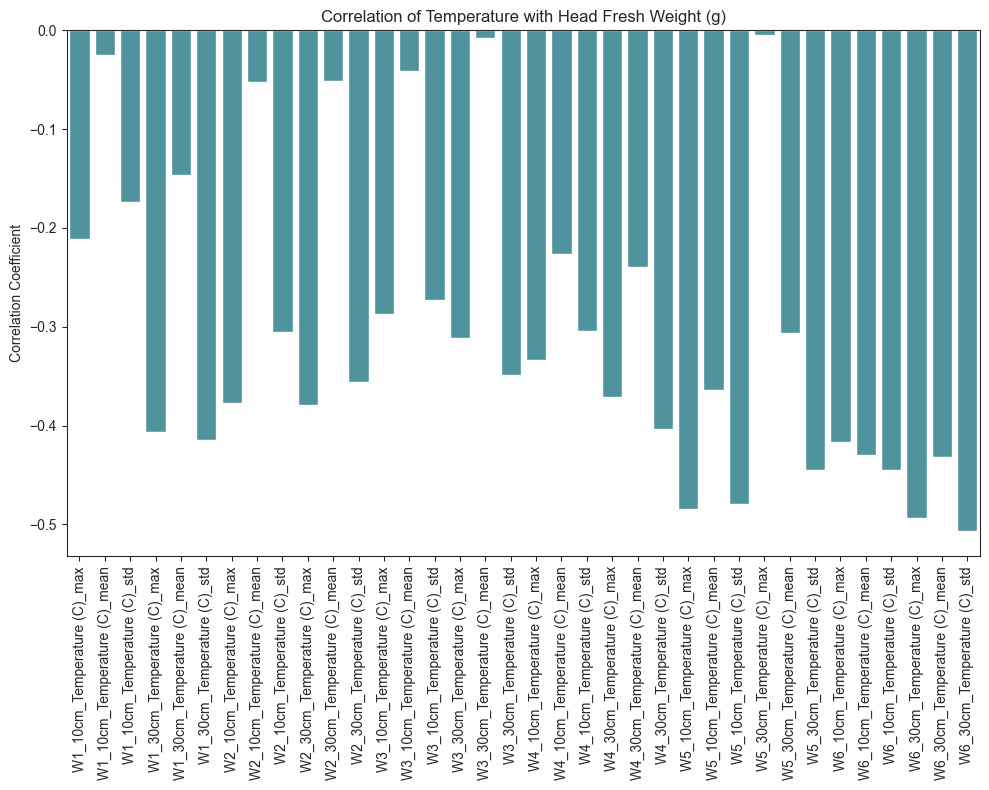

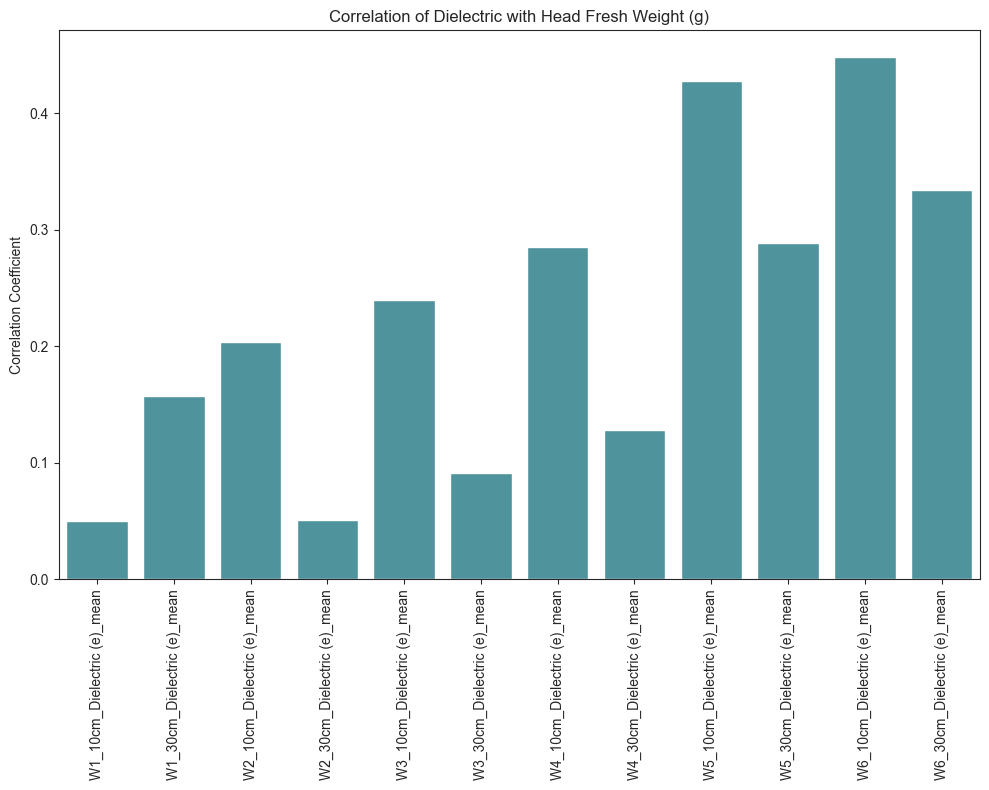

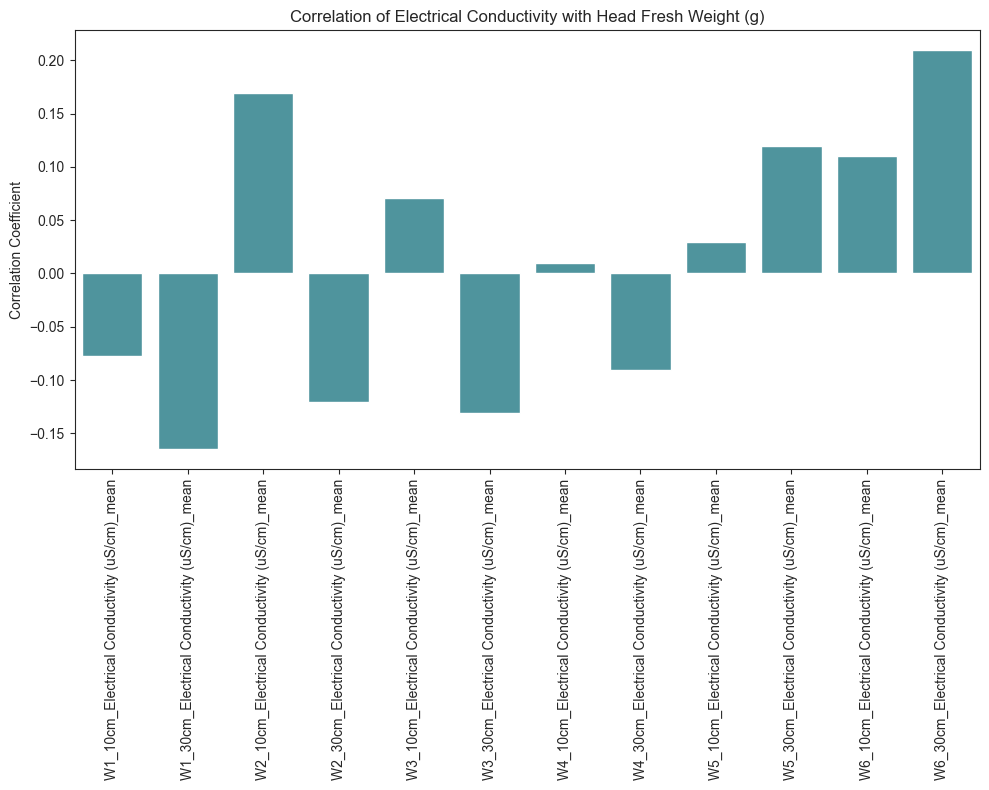

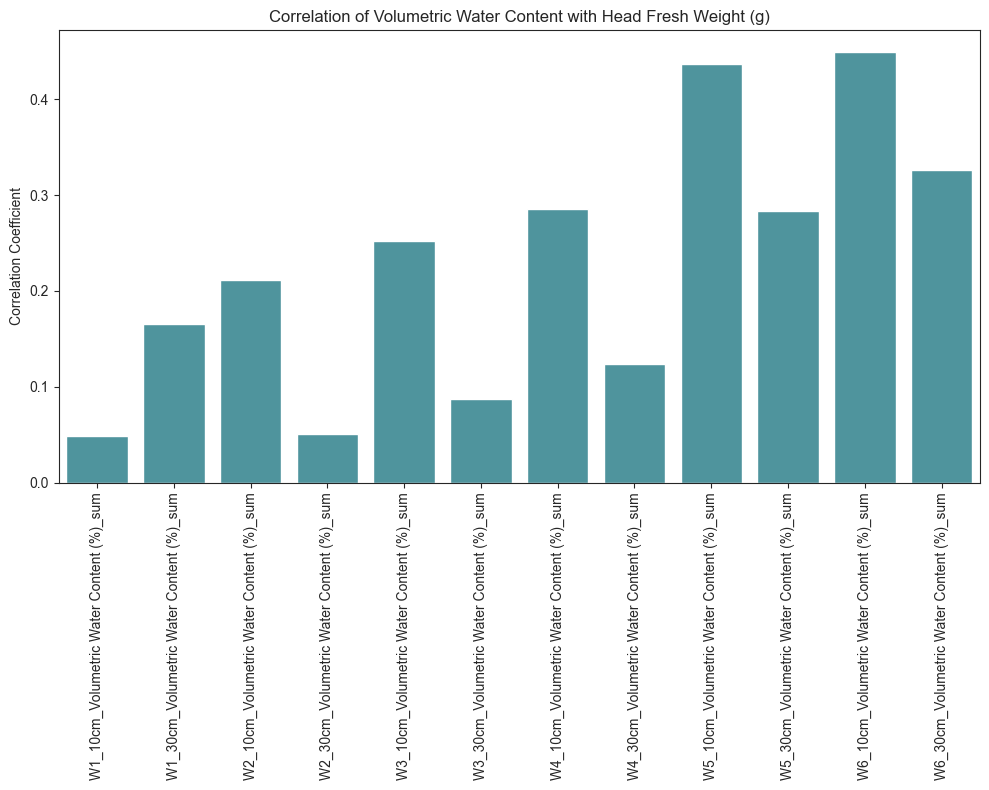

In [40]:
# B_crop_data
imp_csv_path = os.path.join(target_dir, "B_processed_data", "B_crop_data.csv")
B_crop_data = pd.read_csv(imp_csv_path)

B_crop_data["Treatment"]     = B_crop_data["Water treatment"] + B_crop_data["Fertiliser treatment"]
B_crop_data[["Bed", "Temp"]] = B_crop_data["ID"].str.split("A", expand = True)
B_crop_data.drop(columns = "Temp", inplace = True)

# Merge
merged_data = pd.merge(B_crop_data, resampled_soil_data_wide, on = ["Bed", "Treatment"], how = "left")
display(merged_data)

# Correlations with Head fresh weight (g)
grouped_correlations = {}
variable_groups      = ["Temperature", "Dielectric", "Electrical Conductivity", "Volumetric Water Content"]

for group in variable_groups:
    group_columns = [col for col in merged_data.columns if group in col]
    correlations  = merged_data[group_columns].corrwith(merged_data["Head fresh weight (g)"])
    grouped_correlations[group] = correlations

for group, correlations in grouped_correlations.items():
    correlations = correlations.reset_index()
    correlations.columns = ["Variable", "Correlation"]
    plt.figure(figsize = (10, 8))
    sns.barplot(data = correlations, x = "Variable", y = "Correlation", color = "#429eaa")
    plt.title(f"Correlation of {group} with Head Fresh Weight (g)")
    plt.ylabel("Correlation Coefficient")
    plt.xlabel(None)
    plt.xticks(rotation = 90, ha = "center")
    plt.tight_layout()
    plt.show()

##### 2.2.5 **Feature Selection**

In [177]:
# Selected features
soil_variables = [col for col in resampled_soil_data_wide.columns if "Temperature" in col or "Dielectric" in col or "Volumetric Water Content" in col]
soil_variables = [col for col in soil_variables if "W5" in col or "W6" in col]

# B_soil_data
B_soil_data = resampled_soil_data_wide[["Bed", "Treatment"] + soil_variables]

#### 2.3 **Export Data File**

In [179]:
exp_csv_path = os.path.join(target_dir, "B_processed_data", "B_soil_data.csv")
B_soil_data.to_csv(exp_csv_path, index = True)